In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

In [95]:
def data_split(data, all = False):

    data_copy = data.copy()
    
    if(all == False):            
        train_data = data_copy[:-365]
        test_data = data_copy[-365:]
    else:
        num_data = data_copy.shape[0]
        split_val = int(num_data*0.8)
        train_data = data_copy[:split_val]
        test_data = data_copy[split_val:]

    X_train = train_data[['Open','High','Low','Volume','Turnover']]
    Y_train = train_data[['Close']]

    X_test = test_data[['Open','High','Low','Volume','Turnover']]
    Y_test = test_data[['Close']]

    return X_train,Y_train,X_test,Y_test
    

In [96]:
def readData(path):
    data = pd.read_csv(path, index_col='Date', parse_dates=True, dayfirst=True)
    data = data.loc['2012-03-01': '2021-01-07']
    data.dropna(inplace = True)
    return data

In [97]:
def volatility(data, Rf):
    
    Nifty = readData('../datasets/inidices/NIFTY 50.csv')
    Nifty = Nifty.loc['2019-1-1':'2021-1-1']

    data = data.loc['2019-1-1':'2021-1-1']

    beta = np.cov(Nifty['Close'], data['Close'])[0][1]/data['Close'].var()

    alpha = (data['Close'][-1] - data['Close'][0])/data['Close'][0] - Rf + beta * ((Nifty['Close'][-1] - Nifty['Close'][0])/Nifty['Close'][0] - Rf)

    return (alpha, beta)

In [98]:
def SVRModel(Xtrain, Ytrain, Xtest, Ytest):
    
    i = 0.0001
    temp = []

    while(i <= 100):
        
        PipelineObject = Pipeline([('Scaler', StandardScaler()), ('svr', LinearSVR(C = i))])
        PipelineObject.fit(Xtrain,Ytrain)
        predictedSVR = PipelineObject.predict(Xtest)
        temp.append([PipelineObject, sqrt(metrics.mean_squared_error(Ytest, predictedSVR)), i])
        i = i * 10
    
    return (min(temp, key = lambda x: x[1]))

In [99]:
def SVRModelFinal(data, c):

    PipelineObject = Pipeline([('Scaler', StandardScaler()), ('svr', LinearSVR(C = c))])
    Xtrain = data[['Open','High','Low','Volume','Turnover']]
    Ytrain = data[['Close']]
    PipelineObject.fit(Xtrain,Ytrain)

    return PipelineObject

In [100]:
def LRModel(Xtrain, Ytrain, Xtest, Ytest):
    
    Regressor = LinearRegression()
    model = Regressor.fit(Xtrain, Ytrain)
    predictedLR = Regressor.predict(Xtest)
    
    return (model, sqrt(metrics.mean_squared_error(Ytest, predictedLR)))

In [101]:
def LRModelFinal(data):

    Regressor = LinearRegression()
    Xtrain = data[['Open','High','Low','Volume','Turnover']]
    Ytrain = data[['Close']]
    model = Regressor.fit(Xtrain, Ytrain['Close'].tolist())
    
    return model

In [102]:
def DTRModel(Xtrain, Ytrain, Xtest, Ytest):

    min_rmse = -1
    min_model = None
    min_maxleaf =None
    
    for max_leaf_nodes in [5, 50, 500, 5000]:
    
        my_model,my_rmse = DTRGetRMSE(max_leaf_nodes, Xtrain, Xtest, Ytrain, Ytest)
    
        if min_rmse==-1 or min_rmse>my_rmse:
            min_rmse=my_rmse
            min_model = my_model
            min_maxleaf = max_leaf_nodes
    
    return (min_model,min_rmse,min_maxleaf)

In [103]:
def DTRModelFinal(data,c_max_leaf_nodes):

    Regressor = DecisionTreeRegressor(max_leaf_nodes=c_max_leaf_nodes)
    Xtrain = data[['Open','High','Low','Volume','Turnover']]
    Ytrain = data[['Close']]
    model = Regressor.fit(Xtrain, Ytrain['Close'].tolist())
    
    return model

In [104]:
def DTRGetRMSE(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    rmse = sqrt(metrics.mean_squared_error(val_y, preds_val))
    return model,rmse

In [105]:
def RFModel(Xtrain, Ytrain, Xtest, Ytest):

    min_rmse = -1
    min_model = None
    min_maxleaf =None
    
    for max_leaf_nodes in [5, 50, 500, 5000]:
    
        my_model,my_rmse = RFGetRMSE(max_leaf_nodes, Xtrain, Xtest, Ytrain, Ytest)
    
        if min_rmse==-1 or min_rmse>my_rmse:
    
            min_rmse=my_rmse
            min_model = my_model
            min_maxleaf = max_leaf_nodes
    
    return min_model,min_rmse,min_maxleaf

In [106]:
def RFGetRMSE(max_leaf_nodes, train_X, val_X, train_y, val_y):
    
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    rmse = sqrt(metrics.mean_squared_error(val_y, preds_val))
    
    return model,rmse

In [107]:
def RFModelFinal(data,c_max_leaf_nodes):

    Regressor = RandomForestRegressor(max_leaf_nodes=c_max_leaf_nodes)
    Xtrain = data[['Open','High','Low','Volume','Turnover']]
    Ytrain = data[['Close']]
    model = Regressor.fit(Xtrain, Ytrain['Close'].tolist())
    
    return model

In [108]:
data = readData('../datasets/companies/LICHSGFIN.csv')

In [109]:
X_train,Y_train,X_test,Y_test = data_split(data, True)

In [110]:
paths = ['../datasets/companies/BAJAJ-AUTO.csv', '../datasets/companies/BAJFINANCE.csv', '../datasets/companies/HDFCBANK.csv', '../datasets/companies/INFY.csv', '../datasets/companies/ITC.csv', '../datasets/companies/LICHSGFIN.csv', '../datasets/companies/PFIZER.csv', '../datasets/companies/RELIANCE.csv', '../datasets/companies/SBIN.csv', '../datasets/companies/TATAMOTORS.csv', '../datasets/companies/TCS.csv']
company = ["BAJAJ-AUTO", "BAJFINANCE", "HDFCBANK", "INFY", "ITC", "LICHSGFIN", "PFIZER", "RELIANCE", "SBIN", "TATAMOTORS", "TCS"]

modelSelection = []
final = []

for i in range(0, len(paths)):
    
    temp = []
    
    data = readData(paths[i])
    
    X_train,Y_train,X_test,Y_test = data_split(data, True)
    
    LR = LRModel(X_train, Y_train, X_test, Y_test)
    SVR = SVRModel(X_train, Y_train['Close'].tolist(), X_test, Y_test['Close'].tolist())
    DTR = DTRModel(X_train, Y_train, X_test, Y_test)
    RF = RFModel(X_train, Y_train, X_test, Y_test)

    temp.append(LR[1])
    temp.append(SVR[1])
    temp.append(DTR[1])
    temp.append(RF[1])

    x = temp.index(min(temp))
    
    alpha, beta = volatility(data, 0.05)

    if(x == 0):
        final.append(["LR -", temp[0]])
        modelSelection.append([company[i], "LR", LRModelFinal(data), alpha, beta])
    elif(x == 1):
        final.append(["SVR -", temp[1]])
        modelSelection.append([company[i], "SVR", SVRModelFinal(data, SVR[2]), alpha, beta])
    elif(x == 2):
        final.append(["DTR -", temp[2]])
        modelSelection.append([company[i], "DTR", DTRModelFinal(data, DTR[2]), alpha, beta])
    elif(x == 3):
        final.append(["RF -", temp[3]])
        modelSelection.append([company[i], "RF", RFModelFinal(data, RF[2]), alpha, beta])

b:\PESU Labs\Data Analytics\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\likit\AppData\Local\Temp/ipykernel_8052/3701300969.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
C:\Users\likit\AppData\Local\Temp/ipykernel_8052/3701300969.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
C:\Users\likit\AppData\Local\Temp/ipykernel_8052/3701300969.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
C:\Users\likit\AppData\Local\Temp/ipykernel_8052/3701300969.py:4: DataCo

In [111]:
for i in final:
    print(i[0], i[1])

SVR - 25.445225669768558
LR - 36.82464782447261
LR - 9.478288393263187
LR - 5.564836521565366
LR - 1.7184544462669864
SVR - 4.0191283964126585
LR - 49.6789191776902
SVR - 11.08480422363284
SVR - 2.7490419409695783
SVR - 1.5447234693877834
LR - 16.724998362287316


In [112]:
for i in modelSelection:
    print(i)

['BAJAJ-AUTO', 'SVR', Pipeline(steps=[('Scaler', StandardScaler()), ('svr', LinearSVR(C=100.0))]), 1.0542303765536762, 3.5225380699309445]
['BAJFINANCE', 'LR', LinearRegression(), 1.2067322958089777, 1.146650518819952]
['HDFCBANK', 'LR', LinearRegression(), -0.2815356988119286, 0.4472519147578698]
['INFY', 'LR', LinearRegression(), 1.8406469530639629, 4.237259362415296]
['ITC', 'LR', LinearRegression(), 1.2118957419733487, 6.408574061906372]
['LICHSGFIN', 'SVR', Pipeline(steps=[('Scaler', StandardScaler()), ('svr', LinearSVR(C=10.0))]), 0.7420716802462886, 4.325034575578774]
['PFIZER', 'LR', LinearRegression(), 0.8641865790968715, 0.32211149738557027]
['RELIANCE', 'SVR', Pipeline(steps=[('Scaler', StandardScaler()), ('svr', LinearSVR(C=100.0))]), 1.0144830960717595, 1.2409524767872928]
['SBIN', 'SVR', Pipeline(steps=[('Scaler', StandardScaler()), ('svr', LinearSVR(C=100.0))]), 2.0591242026710783, 9.265440119793466]
['TATAMOTORS', 'SVR', Pipeline(steps=[('Scaler', StandardScaler()), ('s

Text(0, 0.5, 'Relative risk compared to the market')

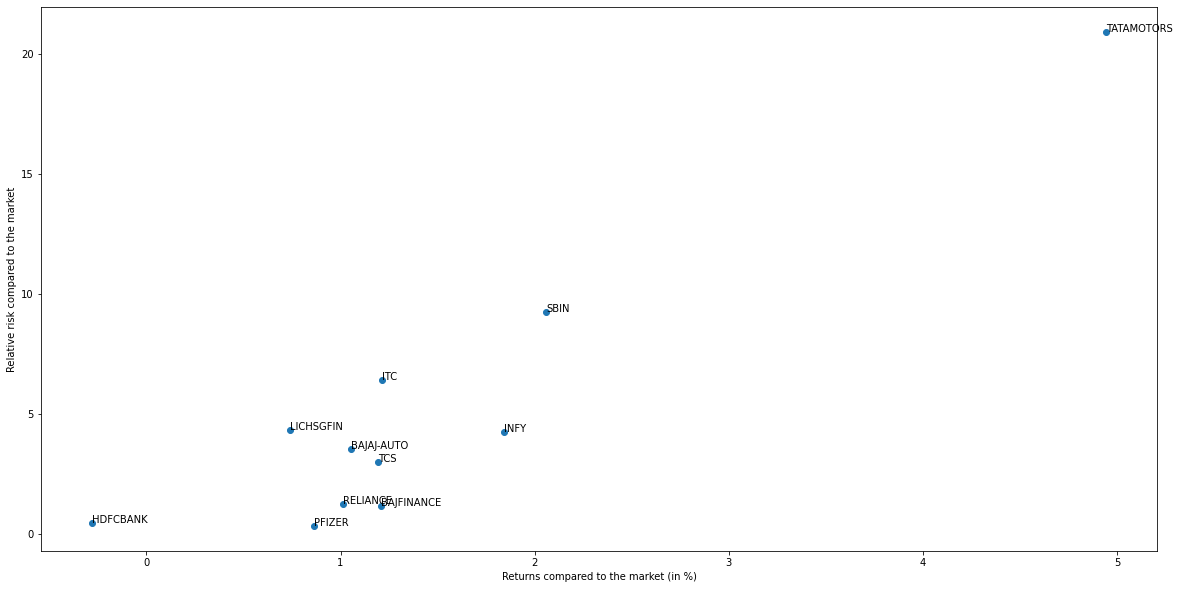

In [115]:
alpha = []
beta = []

for i in modelSelection:
    alpha.append(i[3])
    beta.append(i[4])

plt.figure(figsize = (20, 10))
plt.scatter(alpha, beta)
for i in range(0, len(modelSelection)):
    plt.annotate(modelSelection[i][0], (alpha[i], beta[i]))

plt.xlabel("Returns compared to the market (in %)")
plt.ylabel("Relative risk compared to the market")